
# 1 El análisis

In [15]:
import os
import winsound
import special_fun as s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as signal
import pywt
from scipy.signal import firwin
#Para que me avise
duration = 1000 
freq = 440 

## 1.1 Carga obtención de los audios

In [4]:
ruta_carpeta = '../Data/audio_and_txt_files'
#Si es en colab
#ruta_carpeta = "/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files" 
lista_archivos = os.listdir(ruta_carpeta)
datos=s.sonido_probando123(lista_archivos,ruta_carpeta)

## Ejemplo del metodo usado

In [32]:
y,sr=librosa.load(list(datos.keys())[20])

In [48]:
def mfreqz(b,a,order,nyq_rate = 1):
    
    """
    Plot the impulse response of the filter in the frequency domain

    Parameters:
        
        b: numerator values of the transfer function (coefficients of the filter)
        a: denominator values of the transfer function (coefficients of the filter)
        
        order: order of the filter 
                
        nyq_rate = nyquist frequency
    """
    
    w,h = signal.freqz(b,a);
    h_dB = 20 * np.log10 (abs(h));
    
    plt.figure();
    plt.subplots_adjust(hspace=0.8)

    plt.subplot(311);
    plt.plot((w/max(w))*nyq_rate,abs(h));
    plt.ylabel('Magnitude');
    plt.title(r'Frequency response. Order: ' + str(order));
    [xmin, xmax, ymin, ymax] = plt.axis();
    
    #plt.xlim((40,60))
    
    plt.grid(True);
    
    plt.subplot(312);
    plt.plot((w/max(w))*nyq_rate,h_dB);
    plt.ylabel('Magnitude (db)');
    plt.title(r'Frequency response. Order: ' + str(order));
    plt.grid(True)
    plt.grid(True)
    
    
    plt.subplot(313);
    h_Phase = np.unwrap(np.arctan2(np.imag(h),np.real(h)));
    plt.plot((w/max(w))*nyq_rate,h_Phase);
    plt.ylabel('Phase (radians)');
    plt.xlabel(r'Normalized Frequency (x$\pi$rad/sample)');
    plt.title(r'Phase response. Order: ' + str(order));
    plt.subplots_adjust(hspace=0.5);
    plt.grid(True)
    plt.show()

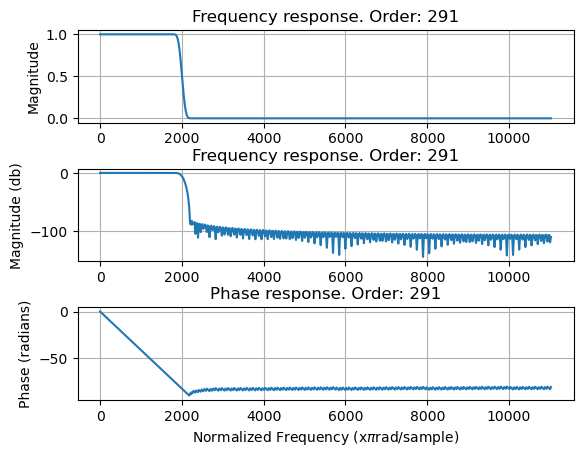

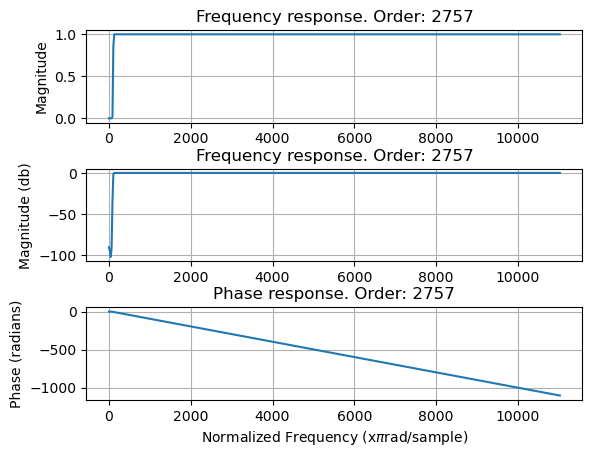

In [49]:
high=100
low=2000
nyq=sr/2
bandalp=(low-high)*0.1
ordenlp=int(5*(nyq/bandalp))
if ordenlp%2==0:
    ordenlp+=1

low_pass=firwin(ordenlp, low/nyq ,window=('kaiser',7.85))
mfreqz(low_pass,1,ordenlp, nyq)

bandahp=(high)*0.2
ordenhp= int(5*(nyq/bandahp))
if ordenhp%2==0:
    ordenhp+=1

high_pass=firwin(ordenhp, high/nyq ,pass_zero="highpass",window=('kaiser',7.85))
mfreqz(high_pass,1,ordenhp, nyq)

In [35]:
y_h = signal.filtfilt(high_pass, 1, y)
y_l = signal.filtfilt(low_pass, 1, y_h)
yfir = np.asfortranarray(y_l)

Text(0, 0.5, 'Potencia')

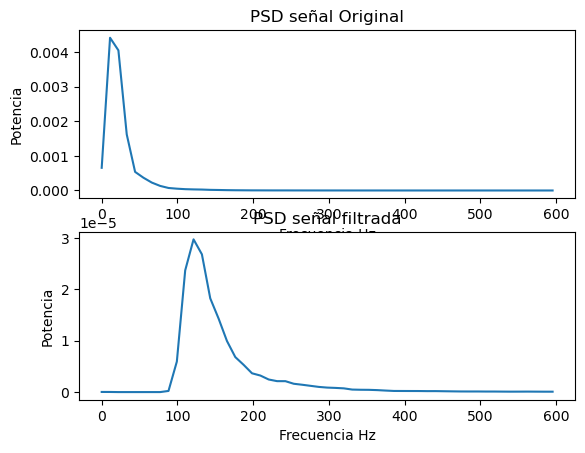

In [37]:
plt.figure()
plt.subplots_adjust(hspace=0.4)
plt.subplot(211)
f,Pxx=signal.welch(y,sr,"hamming",2000,1000,scaling="density")
r=f<600
plt.plot(f[r],Pxx[r])
plt.title("PSD señal Original")
plt.xlabel("Frecuencia Hz")
plt.ylabel("Potencia")


plt.subplot(212)
f,Pxx=signal.welch(yfir,sr,"hamming",2000,1000,scaling="density")
r=f<600
plt.plot(f[r],Pxx[r])
plt.title("PSD señal filtrada")
plt.xlabel("Frecuencia Hz")
plt.ylabel("Potencia")


In [38]:
data_wavelet = pywt.wavedec( yfir, 'db6', level=8 )  
details = data_wavelet[1:]
details_t = s.wthresh(details)
rec=list()
rec.append(data_wavelet[0])
for i in range(len(details_t)): 
    rec.append(details_t[i]) 
x_rec = pywt.waverec( rec, 'db6') 
x_rec = x_rec[0:y.shape[0]]
y_fil=np.squeeze(yfir - x_rec)

Text(0.5, 1.0, 'Discriminación ciclos cardíacos')

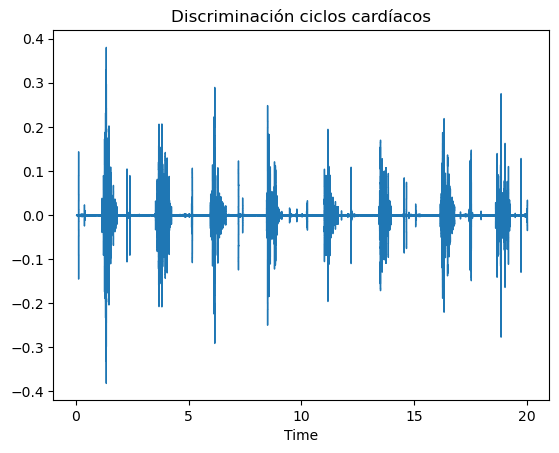

In [39]:
librosa.display.waveshow(x_rec,sr=sr)
plt.title("Discriminación ciclos cardíacos")

Text(0, 0.5, 'Potencia')

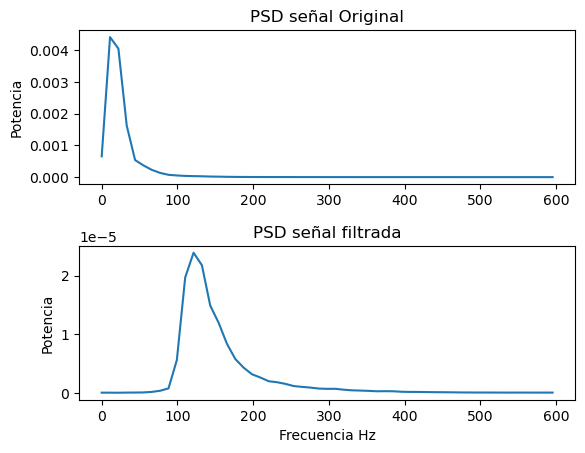

In [43]:
plt.figure()
plt.subplots_adjust(hspace=0.4)
plt.subplot(211)
f,Pxx=signal.welch(y,sr,"hamming",2000,1000,scaling="density")
r=f<600
plt.plot(f[r],Pxx[r])
plt.title("PSD señal Original")
plt.ylabel("Potencia")


plt.subplot(212)
f,Pxx=signal.welch(y_fil,sr,"hamming",2000,1000,scaling="density")
r=f<600
plt.plot(f[r],Pxx[r])
plt.title("PSD señal filtrada")
plt.xlabel("Frecuencia Hz")
plt.ylabel("Potencia")


# Generación de espectros

In [50]:
def custom_filter(fs,low=2000,high=100):
    nyq=fs/2
    bandalp=(low-high)*0.1
    ordenlp=int(5*(nyq/bandalp))
    if ordenlp%2==0:
        ordenlp+=1

    low_pass=firwin(ordenlp, low/nyq ,window=('kaiser',7.85))

    bandahp=(high)*0.2
    ordenhp= int(5*(nyq/bandahp))
    if ordenhp%2==0:
        ordenhp+=1
    high_pass=firwin(ordenhp, high/nyq ,pass_zero="highpass",window=('kaiser',7.85))

    return low_pass,high_pass

In [51]:
low_pass,high_pass=custom_filter(datos[list(datos.keys())[0]][1])

In [52]:
def el_filtrador(data,low_pass,high_pass,nivel=10):
    y_h = signal.filtfilt(high_pass, 1, data)
    y_l = signal.filtfilt(low_pass, 1, y_h)
    y = np.asfortranarray(y_l)
    data_wavelet = pywt.wavedec( y, 'db6', level=nivel )  
    details = data_wavelet[1:]
    details_t = s.wthresh(details)
    rec=list()
    rec.append(data_wavelet[0])
    for i in range(len(details_t)): 
        rec.append(details_t[i]) 
    x_rec = pywt.waverec( rec, 'db6') 
    x_rec = x_rec[0:y.shape[0]]
    y_fil=np.squeeze(y - x_rec)
    return y_fil

In [54]:
def filtrar_todo(datos,low_pass,high_pass,level=10):
    fil={}
    for i in list(datos.keys()):
        y_fil=el_filtrador(datos[i][0],low_pass,high_pass,nivel=10)
        fil[i]=y_fil
    return fil

In [55]:
fil=filtrar_todo(datos,low_pass,high_pass,10)
winsound.Beep(freq, duration)

In [56]:
def welch_a(data,sr,rate):
    f,Pxx=signal.welch(data,sr,"hamming",rate[0],rate[1])
    return Pxx[f<1000]

In [59]:
def ciclos(datos,fil,fs,welchrate):
    sound_sanos=[]
    sound_crep=[]
    sound_sil=[]
    welch_sanos=[]
    welch_crep=[]
    welch_sil=[]
    los_wav=list(datos.keys())
    los_txt=[i.replace(".wav",".txt") for i in los_wav]
    for i in range(len(los_txt)):
        d=pd.read_csv(los_txt[i],sep="\t",header=None,names=["ini","end","crackles","wheezes"])
        for index,row in d.iterrows():
            paciente=los_wav[i]
            filti=fil[paciente]
            ini=int(row["ini"]*fs)
            fin=int(row["end"]*fs)
            ciclo=filti[ini:fin]
            if len(ciclo)>=40000:
                ciclo=ciclo[:40001]
                guelch=welch_a(ciclo,sr,welchrate)
                if (int(row["wheezes"])==1) & (int(row["crackles"])==0):
                    sound_sil.append(ciclo)
                    welch_sil.append(guelch)
                if (int(row["crackles"])==1) & (int(row["wheezes"])==0):
                    sound_crep.append(ciclo)
                    welch_crep.append(guelch)
                if (int(row["wheezes"])==0) & (int(row["crackles"])==0):
                    sound_sanos.append(ciclo)
                    welch_sanos.append(guelch)
    return sound_sanos,sound_crep,sound_sil,welch_sanos,welch_crep,welch_sil


In [60]:
sound_sanos,sound_crep,sound_sil,welch_sanos,welch_crep,welch_sil=ciclos(datos,fil,sr,[2000,1000])

In [72]:
print(len(sound_sanos))
print(len(sound_crep))
print(len(sound_sil))


2633
1631
655


(0.0, 500.0)

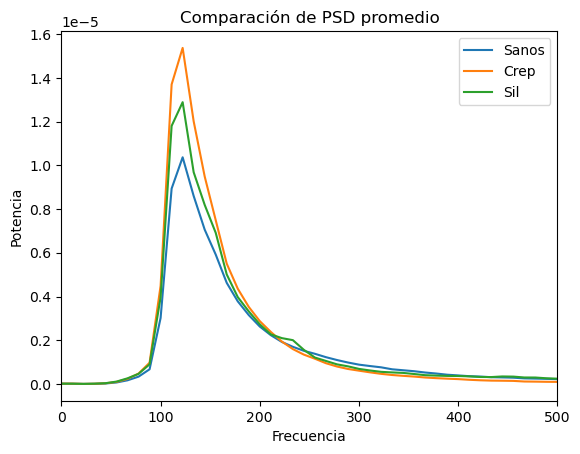

In [65]:
a=plt.figure()
prom=[welch_sanos,welch_crep,welch_sil]
new_prom=[]
f=np.linspace(0,1000,len(prom[0][0]))
for i in prom:
    new_prom.append(np.mean(i,axis=0))
for i in new_prom:
    plt.plot(f,i)
plt.title("Comparación de PSD promedio")
plt.legend(["Sanos","Crep","Sil"])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia")
plt.xlim(0,500)


In [66]:
df=pd.DataFrame( np.array(new_prom))
df.to_csv("promedios.csv",index=False)

In [67]:
prom= np.loadtxt('promedios.csv', delimiter=',')
promedios=prom[1:]

## Rangos de comparación para la PSD

Text(0.5, 0, 'Frecuencia [Hz]')

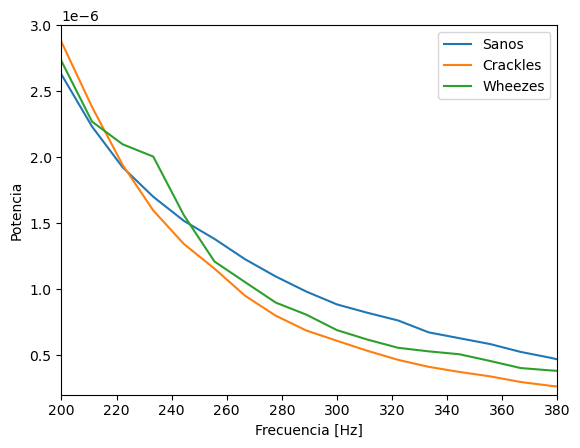

In [71]:
s.grafiquelo(new_prom,[200,380],[0.2e-6,3e-6])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia [Hz]")

Text(0.5, 0, 'Frecuencia [Hz]')

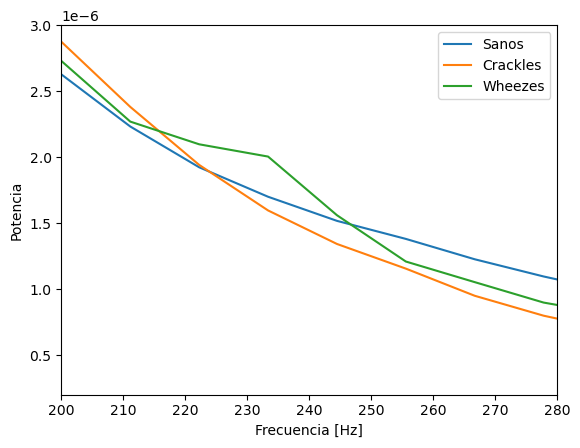

In [73]:
s.grafiquelo(new_prom,[200,280],[0.2e-6,3e-6])
plt.ylabel("Potencia")
plt.xlabel("Frecuencia [Hz]")

In [74]:
guelch=[welch_sanos,welch_crep,welch_sil]
listas=[sound_sanos,sound_crep,sound_sil]

In [75]:
def el_fraccionador(data,fmin=75,fmax=250):
    new_data=[]
    for paciente in data:
        new_ciclo=[]
        for ciclo in paciente:
                f=np.linspace(0,1000,len(ciclo))
                r=(fmax>f) & (fmin>f)
                new_ciclo.append(ciclo[r])
        new_data.append(new_ciclo)
    return new_data

In [76]:
def el_finalizador(data,data_sound,fmin=350,fmax=600):
    def sumatoria(data_frac):
            sum_datos.append(np.sum(data_frac))
    def mediana(data):
            mediana_datos.append(np.median(data))
    def varianza(sound_data,estado):
            var_datos.append(np.var(sound_data))
            fin_estado.append(estado)
    data_frac=el_fraccionador(data,fmin,fmax)
    estado=["Healthy","Crackles","Wheezes"]
    fin_estado=[]
    sum_datos=[]
    mediana_datos=[]
    var_datos=[]
    for i in range(len(estado)):
        status=estado[i]
        a_data=data[i]
        sound_data=data_sound[i]
        a_data_frac=data_frac[i]
        for ciclo in range(len(a_data)):
            sumatoria(a_data_frac[ciclo])
            mediana(a_data[ciclo])
            varianza(sound_data[ciclo],status)
    d={}
    d["Estado"]=fin_estado
    d["Sumatoria"]=sum_datos
    d["Mediana"]=mediana_datos
    d["Varianza"]=var_datos
    d=pd.DataFrame(d)
    return d

In [77]:
d=el_finalizador(guelch,listas,200,280)
d

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,5.556148e-07,4.686493e-10,0.000008
1,Healthy,6.529095e-07,2.819616e-10,0.000009
2,Healthy,6.096350e-07,2.985569e-10,0.000009
3,Healthy,5.567451e-07,2.556868e-10,0.000008
4,Healthy,5.016411e-07,3.071286e-10,0.000007
...,...,...,...,...
4914,Wheezes,1.017147e-05,1.164674e-08,0.000136
4915,Wheezes,9.649835e-06,8.796041e-09,0.000129
4916,Wheezes,1.124116e-06,7.448796e-10,0.000015
4917,Wheezes,9.903341e-07,4.516410e-10,0.000013


In [79]:
d.to_csv("Data_set_200_280.csv",index=False)

## Estadistica

In [ ]:
#libreria para manejo de NDARRAY
import scipy as sp
#libreria para graficar
import matplotlib.pyplot as plt
#Lector de archivos csv
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols

import sympy as sym

from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu
from scipy.stats import levene
import pingouin as pg
